Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1  # grayscale

import numpy as np


def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels


train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(
        tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
        [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [
                            1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(
            hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [6]:
num_steps = 1001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' %
                  accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(
        test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.743091
Minibatch accuracy: 12.5%
Validation accuracy: 9.1%
Minibatch loss at step 100: 1.177613
Minibatch accuracy: 68.8%
Validation accuracy: 63.8%
Minibatch loss at step 200: 0.761327
Minibatch accuracy: 75.0%
Validation accuracy: 77.5%
Minibatch loss at step 300: 0.124678
Minibatch accuracy: 93.8%
Validation accuracy: 79.2%
Minibatch loss at step 400: 0.693378
Minibatch accuracy: 75.0%
Validation accuracy: 78.4%
Minibatch loss at step 500: 1.013936
Minibatch accuracy: 68.8%
Validation accuracy: 80.5%
Minibatch loss at step 600: 0.972424
Minibatch accuracy: 75.0%
Validation accuracy: 81.8%
Minibatch loss at step 700: 0.423723
Minibatch accuracy: 87.5%
Validation accuracy: 82.4%
Minibatch loss at step 800: 0.695757
Minibatch accuracy: 75.0%
Validation accuracy: 83.0%
Minibatch loss at step 900: 0.454602
Minibatch accuracy: 81.2%
Validation accuracy: 82.7%
Minibatch loss at step 1000: 0.285260
Minibatch accuracy: 93.8%
Validation accuracy: 83.6%


---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [7]:
def make_convnet_with_strides(num_labels=num_labels):
    def model_fn(*, data, is_training, labels=None):
        conv1 = tf.layers.conv2d(
            data, depth, [patch_size, patch_size],
            strides=2, padding='SAME',
            activation=tf.nn.relu,
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
            bias_initializer=tf.zeros_initializer(),
            name='conv1')
        conv2 = tf.layers.conv2d(
            conv1, depth, [patch_size, patch_size],
            strides=2, padding='SAME',
            activation=tf.nn.relu,
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
            bias_initializer=tf.constant_initializer(1.0),
            name='conv2')
        fc1 = tf.layers.dense(
            tf.contrib.layers.flatten(conv2), num_hidden,
            activation=tf.nn.relu,
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
            bias_initializer=tf.constant_initializer(1.0),
            name='fc1')
        logits = tf.layers.dense(
            fc1, num_labels,
            activation=tf.nn.relu,
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
            bias_initializer=tf.constant_initializer(1.0),
            name='logits')
        probs = tf.nn.softmax(logits)
        if labels is None:
            return probs
        else:
            loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits),
                name='loss')
            return probs, loss
    return model_fn

def make_logistic_regression(num_labels=num_labels):
    def model_fn(*, data, is_training, labels=None):
        with tf.variable_scope('logits'):
            data = tf.contrib.layers.flatten(data)
            logits = tf.layers.dense(
                data, num_labels,
                kernel_regularizer=tf.nn.l2_loss)
        probs = tf.nn.softmax(logits, name='probs')
        if labels is None:
            return probs
        else:
            loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(
                    labels=labels, logits=logits), name='loss')
            return probs, loss
    return model_fn

def make_adam(learning_rate=0.001):
    def train_op_fn(loss):
        optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.minimize(loss)
        return train_op
    return train_op_fn

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
        
class History:
    _all_groups = ('batch', 'valid', 'test')
    _all_metrics = ('loss', 'accuracy')
    
    def __init__(self):
        self.groups = OrderedDict((group, {}) for group in self._all_groups)
    
    def log(self, step, group, *, loss=None, accuracy=None):
        group = self.groups[group]
        group.setdefault(step, {})
        if loss is not None:
            group[step]['loss'] = loss
        if accuracy is not None:
            group[step]['accuracy'] = accuracy
            
    def display(self, step, groups=_all_groups, metrics=_all_metrics):
        groups = self._get_groups(groups)
        columns = ['step: {}'.format(step)]
        for metric in metrics:
            for name, group in groups.items():
                if step not in group or metric not in group[step]:
                    continue
                value = group[step][metric]
                columns.append('{group} {metric}: {value:.3f}'.format(
                    group=name, metric=metric, value=value))
        print('  '.join(columns))

    def plot(self, groups=_all_groups, metrics=_all_metrics, title=None):
        groups = self._get_groups(groups)
        plt.figure(figsize=(12, 4))
        if title is not None:
            plt.suptitle(title)
        for i, metric in enumerate(metrics):
            plt.subplot(1, len(metrics), i + 1)
            for name, group in groups.items():
                steps, values = [], []
                for step in sorted(group.keys()):
                    if metric not in group[step]:
                        continue
                    steps.append(step)
                    values.append(group[step][metric])
                if steps:
                    plt.plot(steps, values, '.-', label=name)
            plt.gca().set_xlim(xmin=0)
            if metric == 'loss':
                plt.gca().set_ylim(ymin=0)
            if metric == 'accuracy':
                plt.gca().set_ylim(ymax=105)
            plt.title(metric)
            plt.xlabel('step')
            plt.legend()
            plt.grid()
        plt.show()
        
    def _get_groups(self, group_names):
        return OrderedDict((name, self.groups[name]) for name in group_names)

running logistic regression
step: 0  batch loss: 2.489  valid loss: 2.291  batch accuracy: 9.375  valid accuracy: 16.230
step: 100  batch loss: 0.709  valid loss: 0.796  batch accuracy: 83.594  valid accuracy: 79.070
step: 200  batch loss: 0.719  valid loss: 0.727  batch accuracy: 80.469  valid accuracy: 81.020
step: 300  batch loss: 0.854  valid loss: 0.700  batch accuracy: 77.344  valid accuracy: 81.470
step: 400  batch loss: 0.657  valid loss: 0.688  batch accuracy: 85.156  valid accuracy: 82.060
step: 500  batch loss: 0.657  valid loss: 0.681  batch accuracy: 82.812  valid accuracy: 82.120
step: 600  batch loss: 0.615  valid loss: 0.675  batch accuracy: 82.031  valid accuracy: 82.010
step: 700  batch loss: 0.702  valid loss: 0.669  batch accuracy: 79.688  valid accuracy: 82.460
step: 800  batch loss: 0.789  valid loss: 0.664  batch accuracy: 78.906  valid accuracy: 82.560
step: 900  batch loss: 0.923  valid loss: 0.663  batch accuracy: 77.344  valid accuracy: 82.690
step: 1000  bat

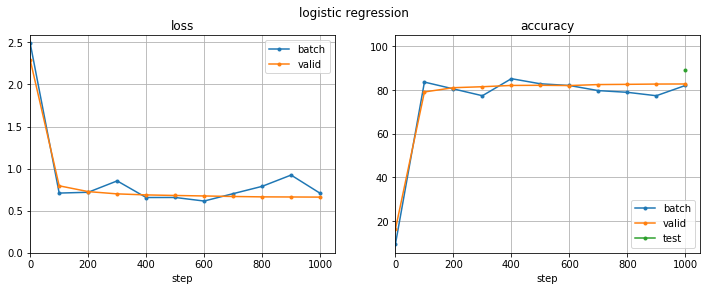

In [9]:
def run(title, model_fn, train_op_fn=None,
        num_steps=1001, batch_size=128, regularization_strength=0.0,
        train_data=train_dataset, train_labels=train_labels,
        valid_data=valid_dataset, valid_labels=valid_labels,
        test_data=test_dataset, test_labels=test_labels):
    print('running', title)

    graph = tf.Graph()
    with graph.as_default():
        data = tf.placeholder(tf.float32, [None, *train_data.shape[1:]],
                              name='data')
        labels = tf.placeholder(tf.float32, [None, *train_labels.shape[1:]],
                                name='labels')
        predictions, loss = model_fn(data=data, labels=labels, is_training=True)
        if regularization_strength is not None:
            loss += regularization_strength * tf.reduce_sum(
                tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES),
                name='regularization_loss')
        with tf.variable_scope('train_op'):
            if train_op_fn is None:
                train_op_fn = make_adam()
            train_op = train_op_fn(loss)
        with tf.variable_scope(tf.get_variable_scope(), reuse=True):
            valid_predictions, valid_loss = model_fn(
                data=tf.constant(valid_data, name='valid_data'),
                labels=tf.constant(valid_labels, name='valid_labels'),
                is_training=False)
            test_predictions = model_fn(
                data=tf.constant(test_data, name='test_data'),
                is_training=False)
    
    with tf.Session(graph=graph) as sess:
        tf.global_variables_initializer().run()
        history = History()
        for step in range(num_steps):
            offset = step * batch_size % (train_data.shape[0] - batch_size)
            batch_data = train_data[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            _, batch_loss, batch_predictions = sess.run(
                [train_op, loss, predictions],
                feed_dict={
                    data: batch_data,
                    labels: batch_labels,
                })
            if step % 100 == 0:
                valid_loss_, valid_predictions_ = sess.run([valid_loss, valid_predictions])
                history.log(step, 'batch', loss=batch_loss,
                            accuracy=accuracy(batch_predictions, batch_labels))
                history.log(step, 'valid', loss=valid_loss_,
                            accuracy=accuracy(valid_predictions_, valid_labels))
                history.display(step)
        history.log(step, 'test', accuracy=accuracy(test_predictions.eval(), test_labels))
        history.display(step, ['test'])
        history.plot(title=title)
        
run('logistic regression', make_logistic_regression())

running convolutional neural network (strides)
step: 0  batch loss: 2.994  valid loss: 2.479  batch accuracy: 7.031  valid accuracy: 9.590
step: 100  batch loss: 0.674  valid loss: 0.725  batch accuracy: 82.031  valid accuracy: 80.010
step: 200  batch loss: 0.696  valid loss: 0.628  batch accuracy: 80.469  valid accuracy: 81.720
step: 300  batch loss: 0.710  valid loss: 0.577  batch accuracy: 77.344  valid accuracy: 83.280
step: 400  batch loss: 0.516  valid loss: 0.536  batch accuracy: 85.938  valid accuracy: 84.230
step: 500  batch loss: 0.426  valid loss: 0.516  batch accuracy: 87.500  valid accuracy: 84.510
step: 600  batch loss: 0.433  valid loss: 0.493  batch accuracy: 85.938  valid accuracy: 85.160
step: 700  batch loss: 0.455  valid loss: 0.476  batch accuracy: 85.156  valid accuracy: 85.710
step: 800  batch loss: 0.610  valid loss: 0.454  batch accuracy: 80.469  valid accuracy: 86.390
step: 900  batch loss: 0.581  valid loss: 0.450  batch accuracy: 81.250  valid accuracy: 86.6

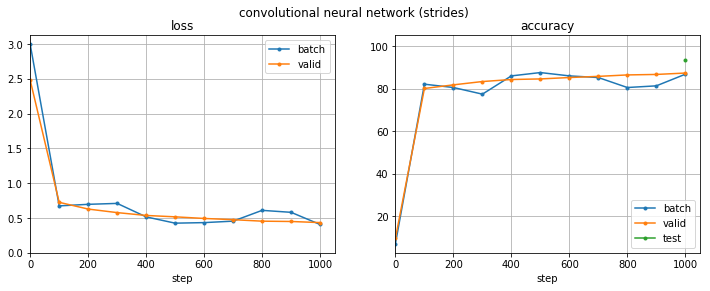

In [13]:
run('convolutional neural network (strides)', make_convnet_with_strides())

running convolutional neural network (pooling)
step: 0  batch loss: 2.917  valid loss: 2.532  batch accuracy: 12.500  valid accuracy: 11.200
step: 100  batch loss: 1.029  valid loss: 1.095  batch accuracy: 66.406  valid accuracy: 64.830
step: 200  batch loss: 0.881  valid loss: 0.823  batch accuracy: 69.531  valid accuracy: 73.660
step: 300  batch loss: 0.816  valid loss: 0.755  batch accuracy: 73.438  valid accuracy: 75.620
step: 400  batch loss: 0.621  valid loss: 0.711  batch accuracy: 78.125  valid accuracy: 76.490
step: 500  batch loss: 0.558  valid loss: 0.683  batch accuracy: 82.031  valid accuracy: 77.300
step: 600  batch loss: 0.632  valid loss: 0.667  batch accuracy: 79.688  valid accuracy: 77.770
step: 700  batch loss: 0.593  valid loss: 0.662  batch accuracy: 80.469  valid accuracy: 77.920
step: 800  batch loss: 0.842  valid loss: 0.640  batch accuracy: 71.094  valid accuracy: 78.270
step: 900  batch loss: 0.706  valid loss: 0.627  batch accuracy: 75.781  valid accuracy: 78

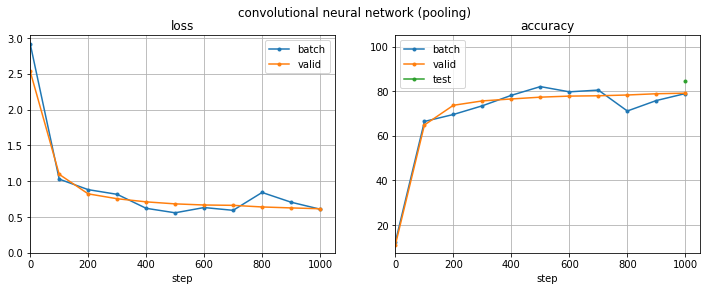

In [11]:
def make_convnet_with_pooling(num_labels=num_labels):
    def model_fn(*, data, is_training, labels=None):
        conv1 = tf.layers.conv2d(
            data, depth, [patch_size, patch_size],
            strides=1, padding='SAME',
            activation=tf.nn.relu,
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
            bias_initializer=tf.zeros_initializer(),
            name='conv1')
        conv1 = tf.layers.max_pooling2d(
            conv1, pool_size=2, strides=2, padding='SAME')
        conv2 = tf.layers.conv2d(
            conv1, depth, [patch_size, patch_size],
            strides=1, padding='SAME',
            activation=tf.nn.relu,
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
            bias_initializer=tf.constant_initializer(1.0),
            name='conv2')
        conv2 = tf.layers.max_pooling2d(
            conv2, pool_size=2, strides=2, padding='SAME')
        fc1 = tf.layers.dense(
            tf.contrib.layers.flatten(conv2), num_hidden,
            activation=tf.nn.relu,
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
            bias_initializer=tf.constant_initializer(1.0),
            name='fc1')
        logits = tf.layers.dense(
            fc1, num_labels,
            activation=tf.nn.relu,
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
            bias_initializer=tf.constant_initializer(1.0),
            name='logits')
        probs = tf.nn.softmax(logits)
        if labels is None:
            return probs
        else:
            loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits),
                name='loss')
            return probs, loss
    return model_fn

run('convolutional neural network (pooling)', make_convnet_with_pooling())

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

running convolutional neural network
step: 0  batch loss: 4.009  valid loss: 2.603  batch accuracy: 12.500  valid accuracy: 10.120
step: 100  batch loss: 1.739  valid loss: 1.519  batch accuracy: 39.062  valid accuracy: 59.460
step: 200  batch loss: 1.224  valid loss: 0.791  batch accuracy: 64.844  valid accuracy: 77.710
step: 300  batch loss: 1.180  valid loss: 0.638  batch accuracy: 67.188  valid accuracy: 81.090
step: 400  batch loss: 0.646  valid loss: 0.579  batch accuracy: 78.125  valid accuracy: 82.620
step: 500  batch loss: 0.776  valid loss: 0.547  batch accuracy: 77.344  valid accuracy: 83.320
step: 600  batch loss: 0.701  valid loss: 0.527  batch accuracy: 82.031  valid accuracy: 84.060
step: 700  batch loss: 0.574  valid loss: 0.520  batch accuracy: 81.250  valid accuracy: 84.110
step: 800  batch loss: 0.882  valid loss: 0.497  batch accuracy: 72.656  valid accuracy: 84.890
step: 900  batch loss: 0.819  valid loss: 0.487  batch accuracy: 75.781  valid accuracy: 85.200
step:

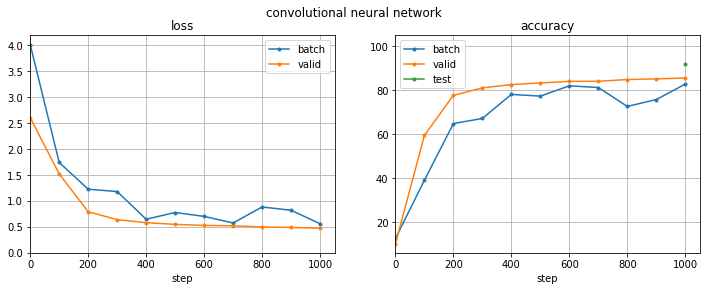

In [12]:
def make_convnet(num_labels=num_labels, dropout_keep_prob=0.5):
    def model_fn(*, data, is_training, labels=None):
        def conv(name, x, depth, kernel_size=3, strides=1, pool_size=2, pool_strides=2):
            with tf.variable_scope(name):
                x = tf.layers.conv2d(
                    x, depth,
                    kernel_size=kernel_size, strides=strides, padding='SAME',
                    activation=tf.nn.relu,
                    kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
                    bias_initializer=tf.zeros_initializer())
                x = tf.layers.max_pooling2d(
                    x, pool_size=pool_size, strides=pool_strides, padding='SAME')
                x = tf.layers.dropout(
                    x, dropout_keep_prob, training=is_training)
            return x
        
        def fc(name, x, size):
            with tf.variable_scope(name):
                x = tf.layers.dense(
                    x, size,
                    activation=tf.nn.relu,
                    kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
                    bias_initializer=tf.constant_initializer(1.0))
                x = tf.layers.dropout(
                    x, dropout_keep_prob, training=is_training)
            return x
        
        conv1 = conv('conv1', data, depth=16)
        conv2 = conv('conv2', conv1, depth=64)
        conv2 = tf.contrib.layers.flatten(conv2)
        fc1 = fc('fc1', conv2, size=128)
        fc2 = fc('fc2', fc1, size=64)

        logits = tf.layers.dense(
            fc2, num_labels,
            activation=tf.nn.relu,
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
            bias_initializer=tf.constant_initializer(1.0),
            name='logits')
        probs = tf.nn.softmax(logits)
        if labels is None:
            return probs
        else:
            loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(
                    labels=labels, logits=logits),
                name='loss')
            return probs, loss
    return model_fn

run('convolutional neural network', make_convnet())